In [4]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [5]:
from fastai.vision.all import *
from fastbook import *

## Image Regression

Download data from the Biwi Kinect Head Pose dataset.

In [6]:
from fastai.vision.all import *
path = untar_data(URLs.BIWI_HEAD_POSE)

In [7]:
Path.BASE_PATH = path
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [11]:
(path/'01').ls()

(#1000) [Path('01/frame_00182_rgb.jpg'),Path('01/frame_00430_pose.txt'),Path('01/frame_00304_rgb.jpg'),Path('01/frame_00103_rgb.jpg'),Path('01/frame_00091_pose.txt'),Path('01/frame_00409_pose.txt'),Path('01/frame_00239_rgb.jpg'),Path('01/frame_00282_rgb.jpg'),Path('01/frame_00149_rgb.jpg'),Path('01/frame_00375_rgb.jpg')...]

In [13]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt') # Last 7 characters are 'rgb.jpg'
img2pose(img_files[0])

Path('16/frame_00182_pose.txt')

In [19]:
img = PILImage.create(img_files[0])
img.shape

(480, 640)

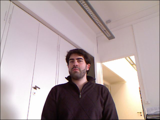

In [21]:
img.to_thumb(160)

In [24]:
## Helper function to extract coordinates of centre of head
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_centre(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

This function can used as our `get_y` function in our `DataBlock`.

In [26]:
get_centre(img_files[0])

tensor([324.0023, 251.5637])

The splitter should not split all images randomly. Remember that the faces come from 24 individual people, and the object of the model is to be able to identify the faces of new people. Hence our validation set should be a set of images of one person who does not appear in the training set.

The `PointBlock` transform block is necessary so that fastai knows that the labels represent coordinates on the image. So when doing data augmentation, it will do the same augmentation to these coordinates as it does to the images.

In [31]:
datablock = DataBlock(
    blocks=(ImageBlock, PointBlock), 
    get_items=get_image_files, 
    get_y=get_centre, 
    splitter=FuncSplitter(lambda o: o.parent.name=='13'), # Returns True only for the faces of one person
    batch_tfms=[*aug_transforms(size=(240, 320)),
                Normalize.from_stats(*imagenet_stats)]
)

Let's check that our data looks right.

In [55]:
dataloaders = datablock.dataloaders(path)
dataloaders.show_batch(max_n=9, figsize=(8,6))

RuntimeError: CUDA out of memory. Tried to allocate 114.00 MiB (GPU 0; 7.94 GiB total capacity; 1.17 GiB already allocated; 12.25 MiB free; 1.21 GiB reserved in total by PyTorch)

In [33]:
xb, yb = dataloaders.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

Range of coordinates is `[-1, 1]`.

In [34]:
yb[0]

TensorPoint([[0.1673, 0.4587]], device='cuda:0')

### Training a model

When we specify with `y_range` that the coordinates are within range `[-1, 1]`, the `Learner` will implement a `sigmoid_range` mapping the neural net's outputs (range `[-inf, inf]`) to the specified range using the sigmoid function.

In [50]:
learner = cnn_learner(dataloaders, resnet18, y_range=(-1,1)).to_fp16()

In [51]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

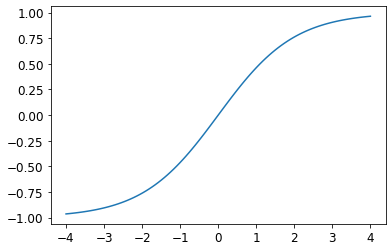

In [52]:
plot_function(partial(sigmoid_range, lo=-1, hi=1), min=-4, max=4)

We didn't specify a loss function, which means we're getting whatever fastai chooses based on our `dataloaders` object. Let's see what it picked for us:

In [53]:
dataloaders.loss_func

FlattenedLoss of MSELoss()

MSE measures the distance that output values are from the target values. The closer, the lower the loss.

We also didn't specify any metrics, because MSE is already a useful metric for this task (although taking the square root might be more interpretable). A similar and even more interpretable metric would be the literal euclidean distance between the predicted point and target point.

Let's find a good learning rate with the learning rate finder.

In [54]:
learner.lr_find()

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.94 GiB total capacity; 1.18 GiB already allocated; 14.25 MiB free; 1.20 GiB reserved in total by PyTorch)